# LLIE Comparison
## General Flow
 - Create bash file to clone llie methods
 - Setup environment
 - Implement LLIE methods
 - Select llie method

## Bash script setup

In [ ]:
%%writefile setup.sh
#!/bin/bash

echo "Cloning LLIE repositories..."
mkdir -p llie_methods
cd llie_methods || exit

# Clone only if not already cloned
[ ! -d "colie" ] && git clone https://github.com/ctom2/colie.git
[ ! -d "SCI" ] && git clone https://github.com/tengyu1998/SCI.git
[ ! -d "Retinexformer" ] && git clone https://github.com/caiyuanhao1998/Retinexformer.git
[ ! -d "Zero-DCE" ] && git clone https://github.com/Li-Chongyi/Zero-DCE.git
cd ..

# Core dependencies
pip install onnxruntime-gpu || pip install onnxruntime
pip install insightface

echo "Checking if guidedFilter is available..."
python3 -c "from cv2.ximgproc import guidedFilter" 2>/dev/null
if [ $? -ne 0 ]; then
    echo "guidedFilter not found — installing OpenCV contrib and dependencies..."
    pip uninstall -y opencv-python opencv-python-headless opencv-contrib-python
    pip install --force-reinstall opencv-contrib-python
    pip install insightface scikit-image matplotlib tqdm
    echo "Installation complete. Please manually restart the runtime now."
else
    echo "guidedFilter is already available — skipping OpenCV reinstall."
fi

# -------------------------------
# Retinexformer Setup
# -------------------------------
echo "[Retinexformer] Installing dependencies..."

cd llie_methods/Retinexformer || exit

# Install core Retinexformer requirements
pip install matplotlib scikit-learn scikit-image opencv-python yacs joblib natsort h5py tqdm tensorboard
pip install einops gdown addict future lmdb numpy pyyaml requests scipy yapf lpips

echo "[Retinexformer] Installing BasicSR..."
python setup.py develop --no_cuda_ext

echo "[Retinexformer] Preparing folders..."
mkdir -p pretrained_weights
mkdir -p Enhancement/DarkFaceTest/input
mkdir -p Enhancement/DarkFaceTest/output

echo "[Retinexformer] Downloading LOL-v1 pretrained weight..."
gdown https://drive.google.com/uc?id=1oPlAzYayqCJUBimXsraWYhKqMZ5jA0SS -O pretrained_weights/LOL_v1.pth

echo "[Retinexformer] Writing DarkFace config..."
cat <<EOL > Options/RetinexFormer_DarkFace.yml
name: "Retinexformer_DarkFace"
model_type: ImageRestorationModel
scale: 1
num_gpu: 1
manual_seed: 0

datasets:
  test:
    name: "DarkFaceTest"
    type: PairedImageDataset
    dataroot_gt: ~
    dataroot_lq: ./Enhancement/DarkFaceTest/input
    io_backend:
      type: disk

network_g:
  type: Retinexformer
  dim: 48
  stage: 3
  num_blocks: [4, 6, 4]
  heads: [1, 2, 4]
  ffn_expansion_factor: 2.66
  bias: False
  LayerNorm_type: WithBias

val:
  save_img: true
  suffix: ~

path:
  pretrain_network_g: pretrained_weights/LOL_v1.pth
  strict_load_g: true
  resume_state: ~
EOL

cd ../../..

echo "[INFO] setup.sh complete."
echo "To run Retinexformer on DarkFace:"
echo "------------------------------------------------------------"
echo "python Enhancement/test_from_dataset.py \\"
echo "    --opt llie_methods/Retinexformer/Options/RetinexFormer_DarkFace.yml \\"
echo "    --weights llie_methods/Retinexformer/pretrained_weights/LOL_v1.pth \\"
echo "    --dataset DarkFace"
echo "------------------------------------------------------------"


Overwriting setup.sh


## Environment Setup

In [59]:
# Local dataset path setup (Ubuntu)
darkface_dir = "darkface/images"
label_dir = "darkface/labels"
output_dir = "output/enhanced_images"
results_dir = "results"

# Check if dataset is visible
from glob import glob
from IPython.display import display
import os

sample_imgs = glob(os.path.join(darkface_dir, "*.png"))
print(f"Found {len(sample_imgs)} images in {darkface_dir}")
display(sample_imgs[:5])


Found 100 images in darkface/images


['darkface/images/17.png',
 'darkface/images/33.png',
 'darkface/images/22.png',
 'darkface/images/63.png',
 'darkface/images/4.png']

In [135]:
!bash setup.sh

Cloning LLIE repositories...
Checking if guidedFilter is available...
guidedFilter is already available — skipping OpenCV reinstall.
[Retinexformer] Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 6.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 6.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 6.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 5.9 MB/s eta 0:00:00a 0:00:01
[Retinexformer] Installing BasicSR...
running develop
/home/ubuntu-22/LLIE/.venv/lib/python3.10/site-packages/setuptools/command/easy_install.py:158: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/ubuntu-22/LLIE/.venv/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecation

In [61]:
import os
import cv2
import json
import shutil
# from retinaface import RetinaFace
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
# from retinaface import RetinaFace
# ---------------------------
# User Configuration
# ---------------------------
output_dir = "./output/enhanced_images"
results_dir = "./results"

# ---------------------------
# Load Dark Face Dataset
# ---------------------------
def load_darkface_images(directory):
    image_paths = sorted(glob(os.path.join(directory, "**/*.png"), recursive=True))
    if len(image_paths) == 0:
        raise FileNotFoundError(f"No images found in {directory}. Please check your dataset path.")
    return image_paths

# LLIE Implementation

## Belyaev Method

In [109]:
#######################################################################################
#       This code was developed by Dr Alexander Belyaev @ Heriot-Watt University      #
#       The original code was then converted to python code by Dean Rowlett           #
#######################################################################################
#
#
#
#######################################################################################
import cv2
import numpy as np
from matplotlib import pyplot as plt
from cv2.ximgproc import guidedFilter
from skimage import img_as_float32
import matplotlib.pyplot as plt

def imbeam(rgb_in, p=0.7, r=0.01, debug=False, label=""):
    # Convert to float32
    rgb_in = img_as_float32(rgb_in)

    if debug:
        print(f"[{label}] Input range: min={rgb_in.min():.4f}, max={rgb_in.max():.4f}")

    hsv = cv2.cvtColor(rgb_in, cv2.COLOR_RGB2HSV)
    v = hsv[:, :, 2]

    # Guided filter expects 8-bit
    v_uint8 = np.uint8(v * 255)
    guided = guidedFilter(v_uint8, v_uint8, radius=15, eps=1e-6)
    guided = guided / 255.0

    v_new = v / (np.power(guided, p) + r)
    v_new = np.clip(v_new, 0, 1)
    hsv[:, :, 2] = v_new

    rgb_out = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    if debug:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs[0].imshow(rgb_in)
        axs[0].set_title(f"Original RGB — {label}")
        axs[1].imshow(rgb_out)
        axs[1].set_title(f"Enhanced RGB — {label}")
        for ax in axs: ax.axis("off")
        plt.show()

    return rgb_out





## CoLIE Method

In [63]:
def run_colie(
    input_folder="drive/MyDrive/darkface-test_images",
    output_folder="output/enhanced_images/CoLIE",
    alpha=1.0,
    beta=0.1,
    gamma=0.1,
    delta=0.001
):
    """
    Runs the CoLIE enhancement script with default or custom parameters.

    Parameters:
        input_folder (str): Path to low-light images.
        output_folder (str): Path where enhanced images will be saved.
        alpha, beta, gamma, delta (float): Loss function weights.
    """
    command = (
        f"python3 llie_methods/colie/colie.py "
        f"--input_folder {input_folder} "
        f"--output_folder {output_folder} "
        f"--alpha {alpha} --beta {beta} --gamma {gamma} --delta {delta}"
    )
    print(f"[INFO] Running CoLIE:\n{command}\n")
    os.system(command)

## SCI

In [122]:
import os
import sys
import torch
import numpy as np
from PIL import Image
from llie_methods.SCI.model import Finetunemodel
from llie_methods.SCI.multi_read_data import MemoryFriendlyLoader
from torch.autograd import Variable
from torch.utils.data import DataLoader


def save_images(tensor, path):
    image_numpy = tensor[0].cpu().float().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    im = Image.fromarray(np.clip(image_numpy * 255.0, 0, 255.0).astype('uint8'))

    # Force JPG extension and format
    path = path.replace(".png", ".jpg")
    im.save(path, 'JPEG')



def run_sci(input_folder, output_folder, model_path="llie_methods/SCI/weights/medium.pt", gpu=0):
    os.makedirs(output_folder, exist_ok=True)

    TestDataset = MemoryFriendlyLoader(img_dir=input_folder, task='test')
    test_queue = DataLoader(TestDataset, batch_size=1, pin_memory=True, num_workers=0)

    if not torch.cuda.is_available():
        print('[ERROR] CUDA not available.')
        return

    model = Finetunemodel(model_path).cuda()
    model.eval()

    with torch.no_grad():
        for _, (input, image_name) in enumerate(test_queue):
            input = Variable(input).cuda()
            image_name = os.path.splitext(os.path.basename(image_name[0]))[0]
            _, r = model(input)
            out_path = os.path.join(output_folder, f"{image_name}.jpg")

            print(f"[SCI] Saving: {out_path}")
            save_images(r, out_path)


## RetinexFormer

In [140]:
import os
import subprocess
import shutil

def run_retinexformer(input_folder="darkface/images",
                      output_folder="output/enhanced_images/Retinexformer",
                      config_path="llie_methods/Retinexformer/Options/RetinexFormer_DarkFace.yml",
                      weights_path="pretrained_weights/LOL_v1.pth"):

    print("[Retinexformer] Starting enhancement...")

    # Make sure output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Run test script with config
    command = [
        "python3",
        "llie_methods/Retinexformer/Enhancement/test_from_dataset.py",
        "--opt", config_path,
        "--weights", weights_path,
        "--dataset", "DarkFaceTest"
    ]
    
    try:
        subprocess.run(command, check=True)
    except subprocess.CalledProcessError as e:
        print("[ERROR] Retinexformer enhancement failed:", e)
        return

    # Move outputs to your pipeline directory
    result_dir = "llie_methods/Retinexformer/results/Retinexformer_DarkFace/visual/DarkFaceTest"
    if os.path.exists(result_dir):
        print(f"[Retinexformer] Copying enhanced images to: {output_folder}")
        for file in os.listdir(result_dir):
            src = os.path.join(result_dir, file)
            dst = os.path.join(output_folder, os.path.splitext(file)[0] + ".jpg")
            img = cv2.imread(src)
            cv2.imwrite(dst, img)
    else:
        print("[WARNING] No output images found. Check result path:", result_dir)

    print("[Retinexformer] Done.")


## Zero-DCE

In [152]:
import os
import cv2
import torch
import numpy as np
from llie_methods.ZeroDCE.ZeroDCE_code.lowlight_train import DCE_net  # from Zero-DCE's model.py
from torchvision import transforms
from glob import glob
from tqdm import tqdm

def run_dce(input_dir, output_dir, weights_path="snapshots/Epoch99.pth", device='cuda' if torch.cuda.is_available() else 'cpu'):
    os.makedirs(output_dir, exist_ok=True)

    # Load model
    model = DCE_net().to(device)
    model.load_state_dict(torch.load(weights_path))
    model.eval()

    # Define image transform
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    img_paths = sorted(glob(os.path.join(input_dir, '*')))

    for img_path in tqdm(img_paths, desc="Zero-DCE Enhancement"):
        img_name = os.path.basename(img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_input = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            enhanced_image, _ = model(img_input)

        # Convert output to uint8 image
        enhanced = enhanced_image.squeeze().clamp(0, 1).cpu().numpy()
        enhanced = (enhanced * 255).astype(np.uint8)
        enhanced = np.transpose(enhanced, (1, 2, 0))  # CHW to HWC
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR)

        save_path = os.path.join(output_dir, img_name)
        cv2.imwrite(save_path, enhanced)


SyntaxError: invalid syntax (lowlight_train.py, line 10)

# Face Recognition

In [64]:
# ---------------------------
# Run RetinaFace Detection
# ---------------------------
def detect_faces(img_dir, result_path):
    from insightface.app import FaceAnalysis

    image_paths = sorted(glob(os.path.join(img_dir, "**/*.jpg"), recursive=True))
    stats = {}  # { filename: [ [x1, y1, x2, y2], ... ] }

    app = FaceAnalysis(name="buffalo_l", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    app.prepare(ctx_id=0, det_size=(640, 640))

    print(f"Running face detection on {len(image_paths)} images...")

    for img_path in tqdm(image_paths, desc="Detecting faces"):
        filename = os.path.basename(img_path)
        try:
            img = cv2.imread(img_path)
            faces = app.get(img)
            boxes = [face.bbox.tolist() for face in faces]
            stats[filename] = boxes
        except Exception as e:
            print(f"Error on {filename}: {e}")
            stats[filename] = []

    with open(result_path, "w") as f:
        json.dump(stats, f, indent=2)

    print(f"Saved detection boxes to: {result_path}")


In [65]:
import onnxruntime
print(onnxruntime.get_available_providers())


['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


# LLIE Pipeline

In [114]:
# !ls
# !echo "---------------------"

# !ls llie_methods/colie/

# !echo "---------------------"
# !cd llie_methods/colie/

# !echo "---------------------"
# !ls ../../content/drive/MyDrive/darkface-test_images/

# !echo "---------------------"
# !ls darkface/images

# !echo "---------------------"
# !python3 llie_methods/colie/colie.py --input_folder darkface/images --output_folder output/enhanced_images/CoLIE --alpha 1 --beta 0.1 --gamma 0.1 --delta 0.001


In [157]:
# llie_face_benchmark.py
import os
import cv2
import json
import shutil
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
"""
Modular LLIE + Face Recognition Pipeline Scaffold
- Runs RetinaFace face detection on Dark Face images before and after enhancement
- Supports multiple LLIE methods (CoLIE, SCI, Retinexformer, etc.)
- Records detection stats and generates visual summary
"""
#########################################################################################
#########################################################################################
#       Select which llie method you would like by commenting out all others            #
#       "None" runs the face recognition on the original data. Other LLIE methods       #
#       enhance images then runs face recognition on enhanced data for comparison       #
#########################################################################################
#########################################################################################
"""                        Select Low-Light image enhancement method                  """
#########################################################################################
# llie_method = "CoLIE"  # Options: "SCI", "Retinexformer", "CoLIE", "ZeroDCE", "none"  #
# llie_method = "SCI"                                                                   #
# llie_method = "Retinexformer"                                                         #
llie_method = "ZeroDCE"                                                               #
# llie_method = "Belyaev"                                                                 #
# llie_method = "none"                                                                  #
#########################################################################################
#########################################################################################
"""                              Pipeline Configuration                               """
#########################################################################################
# RUN_ENHANCEMENT = True                                                                  #
RUN_ENHANCEMENT = False                                                               #
RUN_FACE_DETECTION = True                                                               #
# RUN_FACE_DETECTION = False                                                            #
#########################################################################################
#########################################################################################

# Configuration paths (adjust if your directory structure changes)
darkface_dir = "darkface/images"
output_dir = "output/enhanced_images"
results_dir = "results"

# ---------------------------
# Apply LLIE Enhancement
# ---------------------------
def enhance_images(method, image_paths, output_subdir):
    os.makedirs(output_subdir, exist_ok=True)
    
    if method == "CoLIE":
        # Use consistent output path
        output_subdir = os.path.join("output/enhanced_images", "CoLIE")
        os.makedirs(output_subdir, exist_ok=True)

        print("CoLIE runs over an entire folder, outside of the main loop")
        print("Saving enhanced images to:", output_subdir)
        print("Found images:", len(glob(os.path.join(darkface_dir, '*.png'))))

        run_colie(input_folder=darkface_dir, output_folder=output_subdir)
        # Debug check
        out_files = glob(os.path.join(output_subdir, "*"))
        print(f"[DEBUG] CoLIE saved {len(out_files)} files to {output_subdir}")
        return

    for img_path in tqdm(image_paths, desc=f"Enhancing ({method})"):
        filename = os.path.basename(img_path)
        img = cv2.imread(img_path)


        # Dummy placeholders — to be replaced with actual LLIE calls
        if method == "none":
            enhanced = img
        elif method == "SCI":
            sci_input_dir = darkface_dir  # Or your working input dir
            sci_output_dir = os.path.join("output/enhanced_images", "SCI")
            os.makedirs(sci_output_dir, exist_ok=True)

            print("[INFO] Running SCI enhancement...")
            run_sci(input_folder=sci_input_dir, output_folder=sci_output_dir)
            return
        elif method == "Retinexformer":
            retinex_output_dir = os.path.join("output/enhanced_images", "Retinexformer")
            os.makedirs(retinex_output_dir, exist_ok=True)

            print("[INFO] Running Retinexformer enhancement...")
            run_retinexformer(
                input_folder=darkface_dir,
                output_folder=retinex_output_dir,
                config_path="llie_methods/Retinexformer/Options/RetinexFormer_DarkFace.yml",
                weights_path="llie_methods/Retinexformer/pretrained_weights/LOL_v1.pth"
            )
            return  # batch enhancement, no per-image saving here

        elif method == "Belyaev":
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            show_debug = filename in ["0.png", "10.png"]  # change to any filename you want to preview
            enhanced_rgb = imbeam(img_rgb, p=0.7, debug=show_debug, label=filename)
            enhanced = cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2BGR)
        else:
            raise ValueError("Unknown LLIE method")

        # Save image with .jpg extension to match RetinaFace input expectations
        filename = os.path.splitext(filename)[0] + ".jpg"
        # Ensure correct format for saving
        enhanced_to_save = np.clip(enhanced * 255, 0, 255).astype(np.uint8)
        cv2.imwrite(os.path.join(output_subdir, filename), enhanced_to_save)

# ---------------------------
# Main Pipeline
# ---------------------------
if __name__ == "__main__":
    os.makedirs(results_dir, exist_ok=True)
    images = load_darkface_images(darkface_dir)

    # Check if baseline result already exists
    original_baseline_dir = os.path.join(output_dir, "original")
    baseline_result_path = os.path.join(results_dir, "none.json")
    if RUN_FACE_DETECTION and not os.path.exists(baseline_result_path):
        os.makedirs(original_baseline_dir, exist_ok=True)
        print("Copying original images for baseline face detection...")
        for img_path in tqdm(images, desc="Copying (none)"):
            filename = os.path.splitext(os.path.basename(img_path))[0] + ".jpg"
            img = cv2.imread(img_path)
            cv2.imwrite(os.path.join(original_baseline_dir, filename), img)

        print("Running RetinaFace on unenhanced images...")
        detect_faces(original_baseline_dir, baseline_result_path)
    elif RUN_FACE_DETECTION:
        print("Skipping original face detection — results already exist.")

    if llie_method != "none":
        method_output_dir = os.path.join(output_dir, llie_method)
        result_json_path = os.path.join(results_dir, f"{llie_method}.json")

        if RUN_ENHANCEMENT and llie_method != "none":
            os.makedirs(method_output_dir, exist_ok=True)
            print(f"Enhancing images with method: {llie_method}")
            enhance_images(llie_method, images, method_output_dir)

        if RUN_FACE_DETECTION:
            if os.path.exists(result_json_path):
                print(f"Skipping detection for {llie_method} — results already exist.")
            else:
                print("Running RetinaFace detection on enhanced images...")
                detect_faces(method_output_dir, result_json_path)

    print("Generating comparison plot...")
    # generate_summary(results_dir, "./results/comparison_plot.png")
    print("Done.")


Skipping original face detection — results already exist.
Running RetinaFace detection on enhanced images...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /home/ubuntu-22/.insightface/models/buffalo_l/1k3d68.onnx la

Detecting faces: 100%|██████████| 100/100 [00:03<00:00, 31.10it/s]

Saved detection boxes to: results/ZeroDCE.json
Generating comparison plot...
Done.


In [155]:
import os
from PIL import Image
import glob

# Folder containing the enhanced PNGs
folder = 'output/enhanced_images/ZeroDCE'
png_files = glob.glob(os.path.join(folder, '*.png'))

for png_path in png_files:
    # Load image
    with Image.open(png_path) as im:
        rgb_im = im.convert('RGB')  # Convert to RGB if needed

        # Set new filename
        jpg_path = png_path.replace('.png', '.jpg')
        
        # Save as JPG
        rgb_im.save(jpg_path, 'JPEG')

    # Optional: delete the original PNG
    os.remove(png_path)
    print(f"Converted and deleted: {png_path}")


Converted and deleted: output/enhanced_images/ZeroDCE/17.png
Converted and deleted: output/enhanced_images/ZeroDCE/33.png
Converted and deleted: output/enhanced_images/ZeroDCE/22.png
Converted and deleted: output/enhanced_images/ZeroDCE/63.png
Converted and deleted: output/enhanced_images/ZeroDCE/4.png
Converted and deleted: output/enhanced_images/ZeroDCE/87.png
Converted and deleted: output/enhanced_images/ZeroDCE/67.png
Converted and deleted: output/enhanced_images/ZeroDCE/60.png
Converted and deleted: output/enhanced_images/ZeroDCE/81.png
Converted and deleted: output/enhanced_images/ZeroDCE/73.png
Converted and deleted: output/enhanced_images/ZeroDCE/98.png
Converted and deleted: output/enhanced_images/ZeroDCE/23.png
Converted and deleted: output/enhanced_images/ZeroDCE/93.png
Converted and deleted: output/enhanced_images/ZeroDCE/31.png
Converted and deleted: output/enhanced_images/ZeroDCE/48.png
Converted and deleted: output/enhanced_images/ZeroDCE/77.png
Converted and deleted: ou

# Data Comparison

## Helper Functions

In [68]:
def detect_faces_with_boxes(img_dir, result_path):
    from insightface.app import FaceAnalysis

    image_paths = sorted(glob(os.path.join(img_dir, "**/*.jpg"), recursive=True))
    stats = {}  # { filename: [ [x1, y1, x2, y2], ... ] }

    app = FaceAnalysis(name="buffalo_l", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    app.prepare(ctx_id=0, det_size=(640, 640))

    print(f"Running face detection on {len(image_paths)} images...")

    for img_path in tqdm(image_paths, desc="Detecting faces"):
        filename = os.path.basename(img_path)
        try:
            img = cv2.imread(img_path)
            faces = app.get(img)
            boxes = [face.bbox.tolist() for face in faces]
            stats[filename] = boxes
        except Exception as e:
            print(f"Error on {filename}: {e}")
            stats[filename] = []

    with open(result_path, "w") as f:
        json.dump(stats, f, indent=2)

    print(f"Saved detection boxes to: {result_path}")

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def evaluate_detection_with_iou(pred_boxes, gt_boxes, iou_thresh=0.5):
    tp, fp, fn = 0, 0, 0
    matched_gt = set()

    for pred in pred_boxes:
        matched = False
        for i, gt in enumerate(gt_boxes):
            if i in matched_gt:
                continue
            if compute_iou(pred, gt) >= iou_thresh:
                tp += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            fp += 1

    fn = len(gt_boxes) - len(matched_gt)
    return tp, fp, fn


## Graphing Comparison Pipeline


=== IoU-based Evaluation Summary ===
Method          |  Precision |   Recall |  F1 Score |            TP |             FP |             FN
------------------------------------------------------------------------------------------
none            |       0.79 |     0.05 |      0.09 |            37 |             10 |            763
Belyaev         |       0.75 |     0.13 |      0.22 |           103 |             35 |            697
CoLIE           |       0.74 |     0.13 |      0.22 |           106 |             37 |            694
SCI             |       0.73 |     0.11 |      0.19 |            85 |             31 |            715
[SKIP] No box file for method: Retinexformer
ZeroDCE         |       0.74 |     0.14 |      0.23 |           109 |             38 |            691


/tmp/ipykernel_8960/4168336556.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  method_colours = plt.cm.get_cmap("tab10", len(methods))


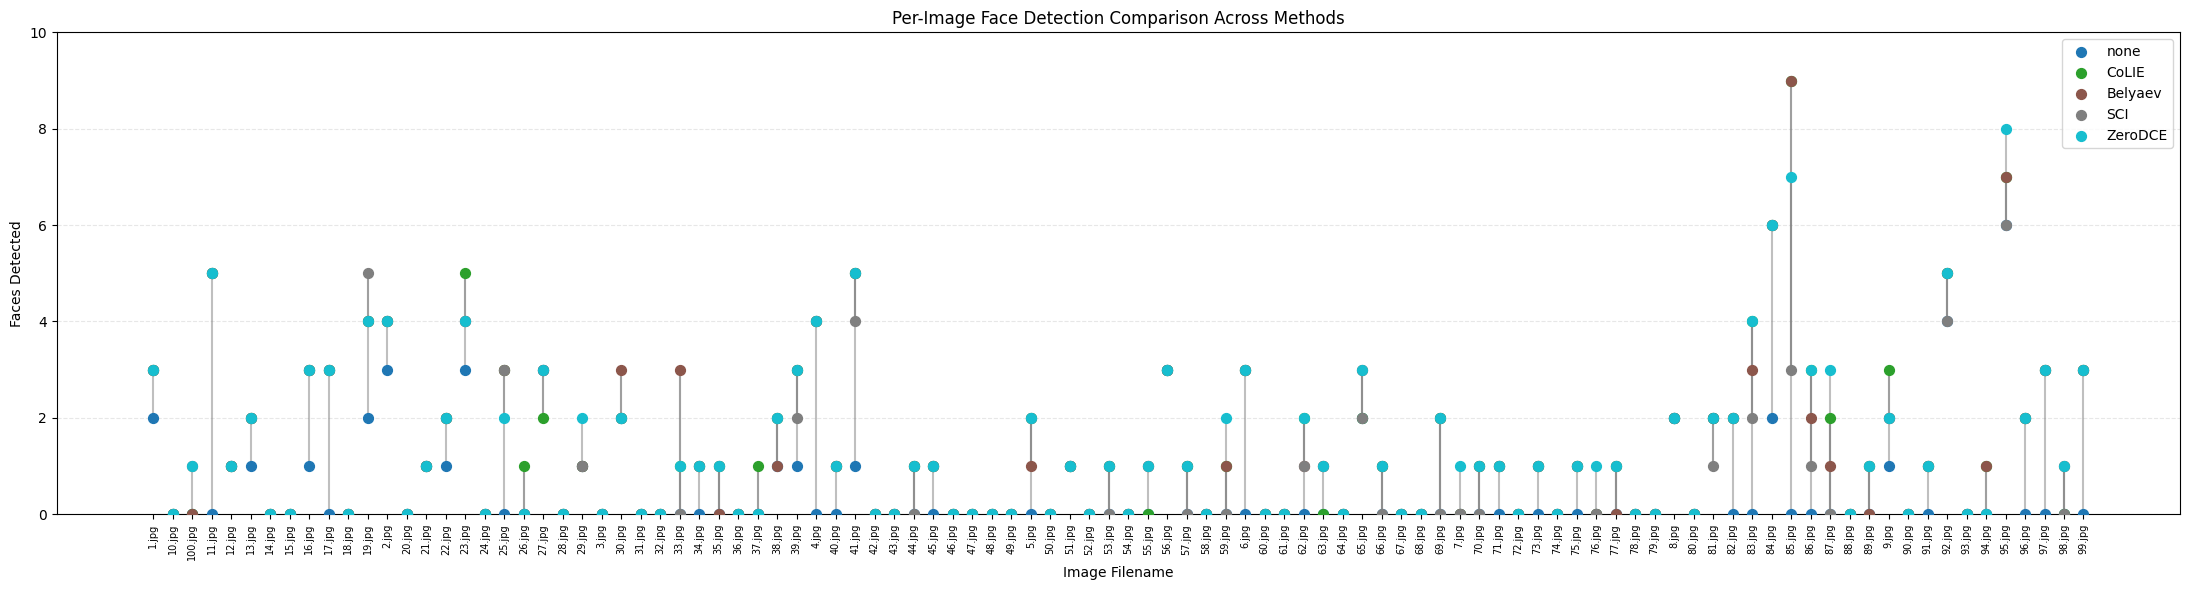

In [160]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Config
# ---------------------------
results_dir = "./results"
labels_dir = "./darkface/labels"
pred_box_dir = "./results"  # full box outputs (e.g., for IoU matching)
methods_to_compare = ["none", "Belyaev", "CoLIE", "SCI", "Retinexformer", "ZeroDCE"]
iou_threshold = 0.5

# ---------------------------
# Load Ground Truth Boxes
# ---------------------------
def load_ground_truth_boxes(label_dir):
    gt = {}
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            img = os.path.splitext(file)[0] + ".jpg"
            with open(os.path.join(label_dir, file)) as f:
                lines = f.readlines()[1:]  # skip count
                boxes = []
                for line in lines:
                    parts = list(map(int, line.strip().split()))
                    if len(parts) == 4:
                        boxes.append(parts)
            gt[img] = boxes
    return gt

# ---------------------------
# IoU Helpers
# ---------------------------
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interW = max(0, xB - xA + 1)
    interH = max(0, yB - yA + 1)
    interArea = interW * interH

    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = box1Area + box2Area - interArea

    return interArea / union if union > 0 else 0

def evaluate_detection_with_iou(pred_boxes, gt_boxes, iou_thresh=0.5):
    matched_gt = set()
    TP, FP = 0, 0

    for pb in pred_boxes:
        matched = False
        for i, gb in enumerate(gt_boxes):
            if i not in matched_gt and compute_iou(pb, gb) >= iou_thresh:
                TP += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            FP += 1

    FN = len(gt_boxes) - len(matched_gt)
    return TP, FP, FN

# ---------------------------
# IoU Evaluation + Summary Table
# ---------------------------
print("\n=== IoU-based Evaluation Summary ===")
print(f"{'Method':15} | {'Precision':>10} | {'Recall':>8} | {'F1 Score':>9} | {'TP':>13} | {'FP':>14} | {'FN':>14}")
print("-" * 90)

gt_boxes = load_ground_truth_boxes(labels_dir)
metric_summary = {}

for method in methods_to_compare:
    pred_path = os.path.join(pred_box_dir, f"{method}.json")
    if not os.path.exists(pred_path):
        print(f"[SKIP] No box file for method: {method}")
        continue

    with open(pred_path) as f:
        pred_boxes = json.load(f)

    TP, FP, FN = 0, 0, 0
    for img, gt in gt_boxes.items():
        preds = pred_boxes.get(img, [])
        tp, fp, fn = evaluate_detection_with_iou(preds, gt, iou_thresh=iou_threshold)
        TP += tp
        FP += fp
        FN += fn

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print(f"{method:15} | {precision:10.2f} | {recall:8.2f} | {f1:9.2f} | {TP:13} | {FP:14} | {FN:14}")

    metric_summary[method] = (precision, recall, f1)

# ---------------------------
# Restore: Vertical Multi-Method Comparison Plot
# ---------------------------
def vertical_multimethod_lines(stats, methods, y_max=None):
    """
    For each image, draw dots for each method and connect them vertically.
    """
    methods = [m for m in methods if m in stats]
    if len(methods) < 2:
        print("Need at least two valid methods.")
        return

    img_keys = sorted(next(iter(stats.values())).keys())
    x = np.arange(len(img_keys))
    method_colours = plt.cm.get_cmap("tab10", len(methods))

    plt.figure(figsize=(22, 6))

    for i, img in enumerate(img_keys):
        y_vals = [stats[m].get(img, 0) for m in methods]
        for j, y in enumerate(y_vals):
            plt.scatter(x[i], y, color=method_colours(j), s=50, zorder=3, label=methods[j] if i == 0 else "")
            if j > 0:
                plt.plot([x[i], x[i]], [y_vals[j - 1], y], color='gray', alpha=0.5)

    plt.xticks(x, img_keys, rotation=90, fontsize=7)
    plt.xlabel("Image Filename")
    plt.ylabel("Faces Detected")
    plt.title("Per-Image Face Detection Comparison Across Methods")
    plt.ylim(0, y_max or max(max(stats[m].values()) for m in methods) + 2)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Load simplified detection counts again for plot (not box-based)
basic_stats = {}
for file in os.listdir(results_dir):
    if file.endswith(".json") and file not in ["boxes", "examples"]:  # Skip box results
        name = os.path.splitext(file)[0]
        with open(os.path.join(results_dir, file)) as f:
            data = json.load(f)
        # Only keep image_name: count (not boxes)
        if isinstance(next(iter(data.values())), list):  # It's boxes not counts
            basic_stats[name] = {k: len(v) for k, v in data.items()}
        else:
            basic_stats[name] = data

# Show connected dot graph again
vertical_multimethod_lines(basic_stats, ["none", "CoLIE", "Belyaev", "SCI", "ZeroDCE"], y_max=10)



## Face Detection Visualisation

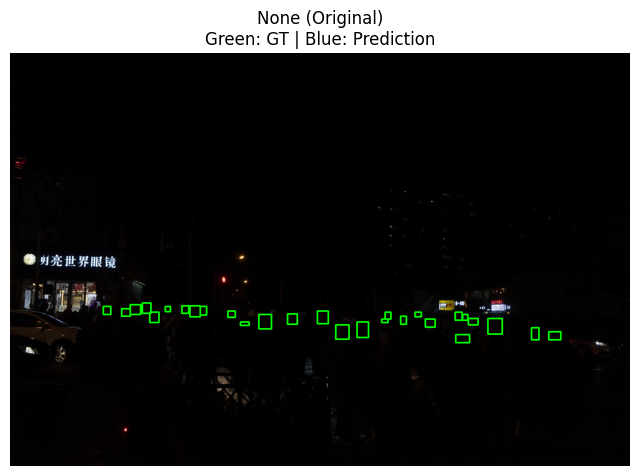

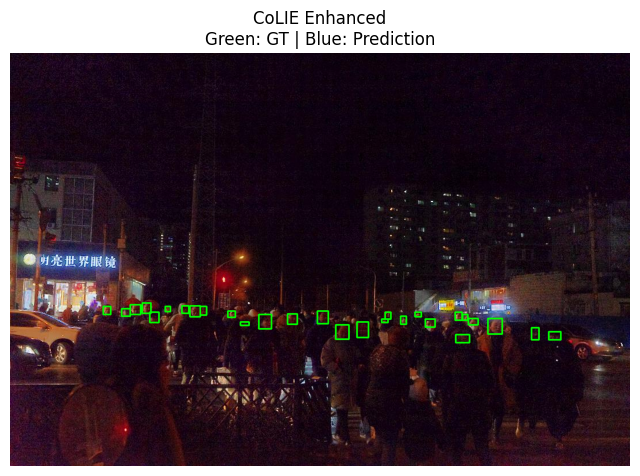

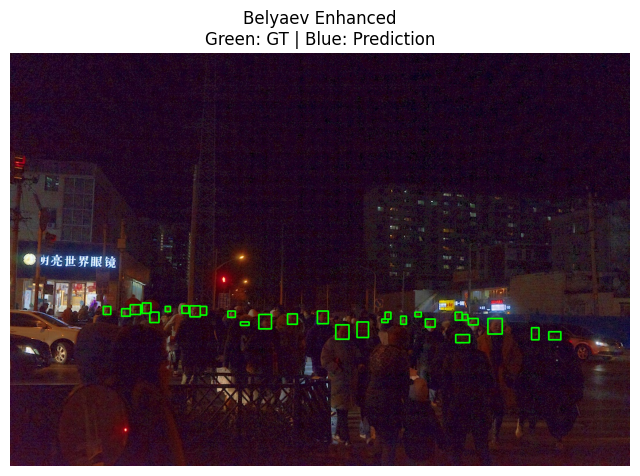

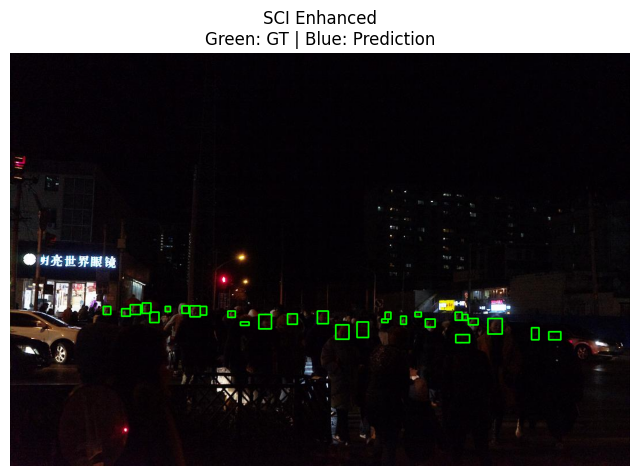

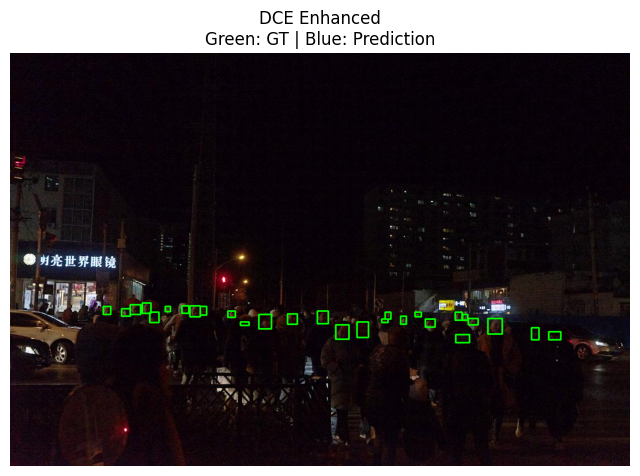

In [161]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_prediction_vs_gt(image_path, pred_boxes, gt_boxes, title="", debug=False):
    if not os.path.exists(image_path):
        print(f"[ERROR] Image not found: {image_path}")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"[ERROR] Failed to load image: {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    pred_boxes = pred_boxes or []
    gt_boxes = gt_boxes or []

    if debug:
        print(f"[INFO] Image: {image_path}")
        print(f"[INFO] Size: {w}x{h}")
        print(f"[INFO] GT Boxes: {len(gt_boxes)} | Pred Boxes: {len(pred_boxes)}")

    # Draw Ground Truth (green)
    for i, box in enumerate(gt_boxes):
        if len(box) != 4:
            continue
        x1, y1, x2, y2 = [int(np.clip(coord, 0, w if idx % 2 == 0 else h)) for idx, coord in enumerate(box)]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        if debug:
            print(f"[GT] Box {i}: ({x1},{y1}) → ({x2},{y2})")

    # Draw Predictions (blue)
    for i, box in enumerate(pred_boxes):
        if len(box) != 4:
            continue
        x1, y1, x2, y2 = [int(np.clip(coord, 0, w if idx % 2 == 0 else h)) for idx, coord in enumerate(box)]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        if debug:
            print(f"[PRED] Box {i}: ({x1},{y1}) → ({x2},{y2})")

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"{title}\nGreen: GT | Blue: Prediction")
    plt.axis('off')
    plt.show()

image_file = "85.jpg"

img_path_none = "output/enhanced_images/original/" + image_file
img_path_collie = "output/enhanced_images/CoLIE/" + image_file
img_path_belyaev = "output/enhanced_images/Belyaev/" + image_file
img_path_sci = "output/enhanced_images/SCI/" + image_file
img_path_dce = "output/enhanced_images/ZeroDCE/" + image_file


# Display side-by-side for comparison
show_prediction_vs_gt(img_path_none, pred_boxes.get("none", {}).get(image_file, []), gt_boxes.get(image_file, []), title="None (Original)")
show_prediction_vs_gt(img_path_collie, pred_boxes.get("CoLIE", {}).get(image_file, []), gt_boxes.get(image_file, []), title="CoLIE Enhanced")
show_prediction_vs_gt(img_path_belyaev, pred_boxes.get("Belyaev", {}).get(image_file, []), gt_boxes.get(image_file, []), title="Belyaev Enhanced")
show_prediction_vs_gt(img_path_sci, pred_boxes.get("SCI", {}).get(image_file, []), gt_boxes.get(image_file, []), title="SCI Enhanced")
show_prediction_vs_gt(img_path_dce, pred_boxes.get("ZeroDCE", {}).get(image_file, []), gt_boxes.get(image_file, []), title="DCE Enhanced")

[INFO] Image Size: 1080x720
[INFO] Number of Boxes: 3
[DEBUG] Drawing box 0: (828, 268) to (920, 373)
[DEBUG] Drawing box 1: (493, 341) to (517, 370)
[DEBUG] Drawing box 2: (564, 345) to (582, 370)


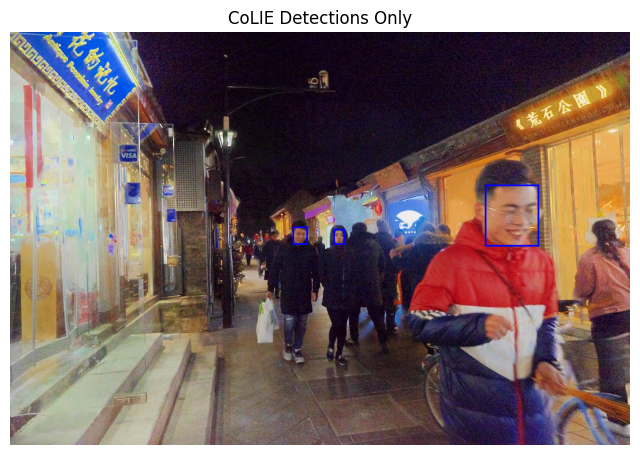

In [96]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

def draw_detections_only_debug(image_path, pred_boxes, title="Detected Faces (Blue Only)"):
    if not os.path.exists(image_path):
        print(f"[ERROR] Image not found: {image_path}")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"[ERROR] Could not load image: {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    print(f"[INFO] Image Size: {w}x{h}")
    print(f"[INFO] Number of Boxes: {len(pred_boxes)}")

    for i, box in enumerate(pred_boxes):
        if len(box) != 4:
            print(f"[WARNING] Skipping invalid box: {box}")
            continue
        x1, y1, x2, y2 = [int(np.clip(coord, 0, w if idx % 2 == 0 else h)) for idx, coord in enumerate(box)]
        if x2 > x1 and y2 > y1:
            print(f"[DEBUG] Drawing box {i}: ({x1}, {y1}) to ({x2}, {y2})")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Blue

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --------------------------
# Load Predicted Boxes
# --------------------------
with open("results/CoLIE.json") as f:
    pred_boxes = {"CoLIE": json.load(f)}

# --------------------------
# Display Detections
# --------------------------
image_file = "1.jpg"
img_path = os.path.join("output/enhanced_images/CoLIE", image_file)
detected = pred_boxes.get("CoLIE", {}).get(image_file, [])

draw_detections_only_debug(img_path, detected, title="CoLIE Detections Only")
